# QAOA (QUANTIC APPROXIMATE OPTIMIZATION ALGORITHM)

## Bibliografía

[PennyLane CodeMap: Introducción a los Variational Quantum Algorithms (VQA)](https://pennylane.ai/codebook/variational-quantum-algorithms/parametrized-quantum-circuits): Puede venir bien por si hay algunas dudas de conceptos fundamentales

[PennyLane CodeMap: QAOA](https://pennylane.ai/codebook/variational-quantum-algorithms/quantum-approximate-optimization-algorithm) Explicación Teórica + Ejercicios de Programación para practicar la implementación

[Tutorial QAOA](https://pennylane.ai/qml/demos/tutorial_qaoa_intro): Explicación teórica + Implementación de Minimum Vertex Cover (no explicado en este cuaderno)

[Ket-G: Hamiltoniano](https://www.youtube.com/watch?v=OXthrvvLhDw): Explicación teórica

[Ket-G: QAOA](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiY16KbjPuOAxXdVKQEHYnvNpcQwqsBegQIFhAG&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3Dvs7Om4h1WPY&usg=AOvVaw33pGt6fRXh8U592fzuIOt8&opi=89978449) Explicación Teórica

[Ket-G: Programando el QAOA](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiY16KbjPuOAxXdVKQEHYnvNpcQwqsBegQIGRAG&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DPqsALMw2Prw&usg=AOvVaw1cvhLFqj2aUj44XyJ9xJoT&opi=89978449): Implementación de Problema de Optimización (el primero)

[Number Partition Problem](https://arxiv.org/pdf/cond-mat/0310317): Paper de este problema (por si queda alguna duda de qué trata)

In [1]:
# INDICAR SI ESTÁS EN GOOGLE COLAB O NO (JUPYTER...)
colab = False
if colab:
    !pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Se trata de un algoritmo cuántico para resolver exclusivamente problemas de **optimización combinatoria**. Al igual que VQE, resuelve problemas del tipo *QUBO* (Quadratic Unconstrained Binary Optimization), es decir, problemas de *combinatoria binaria* en los que la función objetivo es de esta forma:

$$
min f(x) = x^T Ax + bx
$$

donde $x = (x_1,...,x_n)$, con $x_i \in \{0,1\}$, $A$ es una matriz tal que el elemento $a_{ij}$ multiplica al producto $x_ix_j$ y $b$ es un vector tal que el elemento $b_i$ multiplica a $x_i$. Este tipo de problemas en un principio *no admite restricciones*, pero se puede probar a introducir las restricciones en la función objetivo en forma de *penalizaciones*, aunque el rendimiento no será tan alto.

Además, también entra en la familia de algoritmos **híbridos**, debido a la combinación de un *circuito cuántico* junto con un algoritmo de *optimización clásica* para hallar los mejores valores de los parámetros del circuito. Forma parte de la familia de algoritmos *Variational Quantum Algorithms (VQA)*

Hay muchos problemas que se pueden resolver con este algoritmo, como algunos problemas relacionados con grafos, el problema del reparto de números ...

## 0. Introducción

Al igual que el VQE, consideramos un circuito cuya matriz asociada de tamaño $2^n \times 2^n$ es:

$$
\begin{pmatrix} f(0) & 0 & \dots & 0 \\ 0 & f(1) & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & f(2^n-1)  \end{pmatrix}
$$

donde $f$ es nuestra función a minimizar. A partir de ahora llamaremos a esta matriz el **Hamiltoniano**, $H$ (de nuevo, no confundir con Hadamard), pero a diferencia del VQE, le añadiremos un sobrenombre: **de coste**, $H_C$.

Queremos de nuevo hallar el estado de mínima energía (es decir, el menor valor de la diagonal/menor valor propio de la matriz); para ello, prepararemos de nuevo un circuito inicial (**ansatz**) que dependa de unos parámetros tal que devuelva un estado $|\psi\rangle$. Luego calcularemos el valor esperado del circuito según nuestro Hamiltoniano $\langle \psi|H|\psi \rangle$, y según lo buena que sea la solución, ajustaremos ligeramente los parámetros del circuito inicial para que la siguiente iteración el valor esperado sea menor. El estado de mínima energía se cumple cuando $|\psi \rangle = |i\rangle$ (siendo $|i\rangle$ el vector con todo ceros salvo un $1$ en la posición $i-1$ y suponiendo que $i$ sea la solución que lleva al mínimo) en la base computacional porque:

$$
\langle i|\begin{pmatrix} f(0) & 0 & \dots & 0 \\ 0 & f(1) & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & f(2^n-1)  \end{pmatrix} |i\rangle
$$

me devolverá $f(i)$.

Hasta aquí todo es igual al VQE; sin embargo, vamos a ver ahora la principal diferencia con el VQE: el ansatz, aunque depende de unos parámetros, ya no va a consistir en puertas $RY$, puertas $CNOT$ y puertas $RX$ para alcanzar todos los estados de la base, sino que va a depender del propio Hamiltoniano de Coste y de otro Hamiltoniano que ahora se explicarán (ponderados por unos coeficientes los cuales optimizaremos).

## 1. Idea del algoritmo

La idea de este algoritmo es que el ansatz consista en combinar *dos tipos de operadores* y *repetirlos* una serie de veces para ir "avanzando por el espacio de soluciones en la dirección correcta" para ir minimizando la energía del sistema y encontrar finalmente el óptimo global que estamos buscando. En concreto, estos operadores dependen de dos **Hamiltonianos** (ya conocemos el de Coste), y se les hace **evolucionar en el tiempo** persiguiendo el objetivo anterior. Los operadores de evolución en el tiempo tienen la siguiente estructura (**ecuación de Schrödinger**):

$$
U(H,t) = e^{−iHt/ℏ} = e^{-i\alpha H}
$$

Donde $\alpha = t/ℏ$ y $H$ es nuestro Hamiltoniano (que además es hermítico).

Implementar un circuito cuántico (nuestro ansatz) que hace la exponencial de un Hamiltoniano compuesto de muchos términos que no conmutan entre sí (es decir, $H = H_1 + ... + H_n$) no es fácil. Por ello, se recurre a la **descomposición de Trotter-Suzuki**, la cual establece que:

$$
e^{A+B} \approx (e^{A/n}e^{B/n})^n
$$

Esto nos sirve para implementar un operador unitario de evolución en el tiempo *aproximado*:

$$
U(H,t,n) = \prod_{j=1}^n \prod_k e^{-iH_kt/n}
$$

de forma que $H = \sum_{k} H_k$ y $U$ se aproxima a $e^{-iHt}$ conforme $n$ se hace más grande.

¿Y qué dos tipos de operadores hemos de usar? Necesitaríamos uno para cuantificar *lo buenas que son las soluciones* y otro para *guiar nuestra búsqueda por el espacio de soluciones*.

Para ello, vamos a explicar el teorema del cual parte este algoritmo: **el teorema adiabático**. Éste dice que si un sistema cuántico empieza en el estado de mínima energía de un Hamiltoniano dependiente del tiempo (el que no conocemos) y evoluciona lo suficientemente lento, el sistema permanecerá en el estado de mínima energía a lo largo de la evolución, terminando en el estado de mínima energía del Hamiltoniano global. Por ello definimos el siguiente Hamiltoniano:

$$
H(t) = (1-t)H_M+tH_C, \ \  t \in [0,1]
$$

donde $H_M$ es el Hamiltoniano de **mezcla** cuyo estado de mínima energía conocemos y que evoluciona a lo largo del tiempo, y $H_C$ es el Hamiltoniano de **coste** (el de antes) que no conmuta con $H_M$, es decir, $[H_M,H_C] = H_MH_C-H_CH_M \neq 0$.

### 1.1 Hamiltoniano de coste



Aunque ya lo hayamos presentado antes, el primer Hamiltoniano está relacionado con la **función objetivo** de nuestro problema de optimización y por ello **cuantifica lo buenas que son nuestras soluciones**.

Como se ha mencionado en la introducción, estamos considerando problemas de optimización *combinatoria*, por lo que normalmente tendremos una serie de elementos $x_i \in \{0, 1\}$ con $i=1, ..., n$ (también se admiten otras codificaciones, como $z_i \in \{-1,1\}$). Éstos son tenidos en cuenta en la función objetivo $f(x_1,...,x_n)$ que buscamos **minimizar** porque su solución óptima corresponde al *estado de mínima energía* (en caso de que la función objetivo sea de forma natural a **maximizar**, se puede cambiar a minimizar *cambiando el signo de la función*).  

Una vez definida nuestra función a minimizar, para pasar de optimización clásica con valores $0$ ó $1$ al mundo cuántico, realizamos la siguiente **transformación** de nuestras variables para estar en formato **Ising**:

$$
x_i = \frac{1-z_i}{2}
$$

porque las nuevas variables $z_i$ se asocian directamente a $Z_i$, la puerta de Pauli $Z$; este cambio de variable funciona porque si $x_i = 0$, $z_i = 1$, y si $x_i = 1$, entonces $z_i$ ha de valer $-1$.

**Atención**: Si hemos codificado nuestro problema con $z_i$, ¡este cambio no es necesario!

### 1.2 Hamiltoniano de Mezcla

El segundo Hamiltoniano está relacionado con el **avanzar por donde haya buenas soluciones**. Para ello, muchas veces nos basta con aplicar la **matriz de Pauli** $X$ como Hamiltoniano de mezcla, por lo que su implementación tiene la siguiente forma:

$$
U(B, \beta) = e^{-i\beta B} = \prod_{j=1}^n e^{-i \beta \sigma_j^x}
$$

lo que equivale a $RX(2\beta)$; es decir, una **rotación en el eje X**. En la implementación, si optimizamos valores de $\beta$, podemos obviar el coeficiente $2$, porque simplemente los valores óptimos serán el doble.

Además, hemos mencionado que su estado de mínima energía es conocido y es del cual partimos para construir el circuito que nos devuelve $|\psi \rangle$. En efecto, en el caso de considerar la matriz de Pauli $X$ como Hamiltoniano de mezcla, ¡su estado de mínima energía es el **estado de superposición**, que es definido con la **matriz** $H$ **de Hadamard**!

$$
|+ \rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{z}  |z\rangle
$$

### 1.3 Sentido físico

Vamos a entender por qué este algoritmo tiene sentido desde el punto de vista físico.

Tras poner a los cubits en superposición, observamos lo siguiente:

El **Hamiltoniano de coste** lo que hace es *separar los cúbits en fase*. Su *probabilidad no cambia*, ya que alterar la fase no cambia la probabilidad de medición, pero sí que se separan según la fase aplicada. El parámetro $\gamma$ determina *cuánto queremos que se separen*; a mayor valor, más se separan, lo cual es bueno (pero con precaución, porque estamos en una esfera de Bloch, y coger un ángulo muy grande puede hacer que se den la vuelta).

La cosa es que *si ahora medimos, veremos todos los estados con la misma probabilidad*. Entonces no nos estamos acercando a la solución óptima... ¿Qué hacemos? Aplicar el **Hamiltoniano de mezcla** para *transformar fase en amplitud* (mediante la rotación que hemos explicado antes).

Partiendo de los estados que hemos separado antes, ahora lo que hacemos es aplicarles esta rotación para que *aquellos más separados (en un sentido) vean aumentadas sus probabilidades de ser observados*, mientras que los que estaban más desplazados pero en el otro sentido tengan menos probabilidades de ser observados. De nuevo, el parámetro $\beta$ determina *cuánto se gira respecto a ese eje*, entonces hay que tener cuidado también con la elección de este parámetro porque si el valor no es adecuado, podemos de nuevo hacer rotar demasiado a las soluciones prometedoras y hacer disminuir su probabilidad de ser observadas.

Para que no sea tan abstracto, pon tu mano derecha extendida hacia adelante, con los dedos (que representan los estados) juntos; este es el punto tras aplicar la superposición de estados. Ahora separa los dedos. El Hamiltoniano de Coste lo que hace es separar los estados (los dedos), de forma que a mayor $\gamma$, más se separan. Ahora, al aplicar el Hamiltoniano de Mezcla, lo que hacemos es rotar los estados (gira la muñeca en sentido antihorario; el pulgar hacia abajo) de forma que los estados que representan buenas soluciones (el meñique y anular) ahora tienen más probabilidades de ser observados (están más arriba), mientras que el pulgar y el índice (malas soluciones), menos probabilidades. A mayor valor de $\beta$, más rotación, pero de nuevo hay que escoger un valor adecuado para no rotar demasiado.

¿Y por qué varias capas de Hamiltonianos de coste y mezcla? Porque buscamos que los Hamiltonianos de coste aumenten la fase de las soluciones buenas (aunque mantengan la probabilidad de ser observadas) y que sean los Hamiltonianos de mezcla los que aumenten esa probabilidad de observación aunque hagan disminuir un poco la fase.

# 2. Implementación

Los pasos a seguir son los siguientes:

- Definir un Hamiltoniano de coste $H_C$ (basándonos en la función a optimizar) cuyo estado de mínima energía lleve a la solución óptima del problema de optimización.
- Definir el Hamiltoniano de mezcla $H_M$ (suele ser el operador de Pauli $X$).
- Construir los circuitos $U_C(\gamma_i)=e^{-i \gamma H_C}$ y $U_M(\beta_i)=e^{-i \beta H_M}$ y crear un ansatz que sea la repetición de ambos.
- Preparar un estado inicial (superposición si el Hamiltoniano de mezcla es el operador de Pauli $X$), y aplicar el ansatz para obtener:

$$
|\psi (\vec{\gamma},\vec{\beta})\rangle = \bigg(\prod_{i=1}^p U_M(\beta_i)U_C(\gamma_i)\bigg) |\psi_0 \rangle
$$

y calcular su valor esperado respecto a $H_C$: $\langle H_C \rangle = \langle \psi (\vec{\gamma},\vec{\beta}) | H_C | \psi (\vec{\gamma},\vec{\beta}) \rangle$,

- Usar técnicas clásicas para optimizar los parámetros $\gamma_1, ..., \gamma_p, \beta_1,...,\beta_p$ (siendo $p$ el número de capas), buscando minimizar el valor esperado del Hamiltoniano de coste.
- Una vez optimizados los parámetros, ejecutar una última vez el ansatz con dichos parámetros optimizados para conseguir una solución cercana al óptimo global.

Vamos a ver en primer lugar un **ejemplo sencillo** de su implementación en Python a través de la librería `PennyLane` para ver el **efecto de cada puerta**.

El objetivo es minimizar la función $f(x_0, x_1, x_2) = 2x_0 -4x_0x_1+3x_1x_2$ donde $x_i \in \{0, 1\}$.

En segundo lugar, tenemos que definir la **función a optimizar** y llevarla al **mundo cuántico** para definir el **Hamiltoniano de Coste**.

En este caso, la función a optimizar es la misma que nos da el enunciado, por lo que lo único que hay que hacer es aplicar la **transformación** $x_i = \frac{1-Z_i}{2}$ y ya tendremos el Hamiltoniano de coste.

$$
f(Z_0, Z_1, Z_2) = 2 \frac{1-Z_0}{2} -4 \frac{1-Z_0}{2} \frac{1-Z_1}{2} + 3 \frac{1-Z_1}{2} \frac{1-Z_2}{2} = \dots = \frac{3}{4} + \frac{Z_1}{4}-\frac{3Z_2}{4} -Z_0Z_1+\frac{3Z_1Z_2}{4}
$$

Definimos el Hamiltoniano de coste en Pennylane de la siguiente manera: por un lado, creamos una lista de **coeficientes** con aquellos de los sumandos de la función, y por otro lado definimos una lista de **observables** con los términos $Z_i$ de cada término (si aparecen multiplicando, también hay que reflejarlo). Después, usamos la función `qml.Hamiltonian(coeficientes, observables)` para crear el Hamiltoniano.

También hay que tener dos cosas en cuenta: si hay coeficientes sin término cuántico, usamos la puerta **identidad** (pero es mejor omitirlos porque simplemente añaden energía al sistema para cualquier solución, por lo que obviarlos supone un ahorro de recursos computacionales). En este caso, como el QAOA por defecto requiere funciones a minimizar, **no hace falta hacer nada**, pero en el caso de que nuestro problema original fuera minimizar una función, *cambiaríamos el signo de los coeficientes*.

En este ejemplo quedaría así:

In [ ]:
observables = [qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(0)@qml.PauliZ(1), qml.PauliZ(1)@qml.PauliZ(2)]
coeficientes = [1/4, -3/4, -1, 3/4]

hamiltoniano_coste = qml.Hamiltonian(coeficientes, observables)

Antes de implementar el Hamiltoniano de mezcla, vamos a ver el efecto de las puertas de Hadamard y posteriormente el efecto del Hamiltoniano de mezcla.

Para ello, definimos el dispositivo donde ejecutar el circuito cuántico (indicándole el número de cables) y asignamos nuestro circuito al dispositivo. Definimos la función aplicando en primer las puertas de Hadamard con `qml.Hadamard(wires = i)` para conseguir la superposición de los estados. Devolvemos en este caso el estado final para calcular las probabilidades de observación de los estados y sus fases.

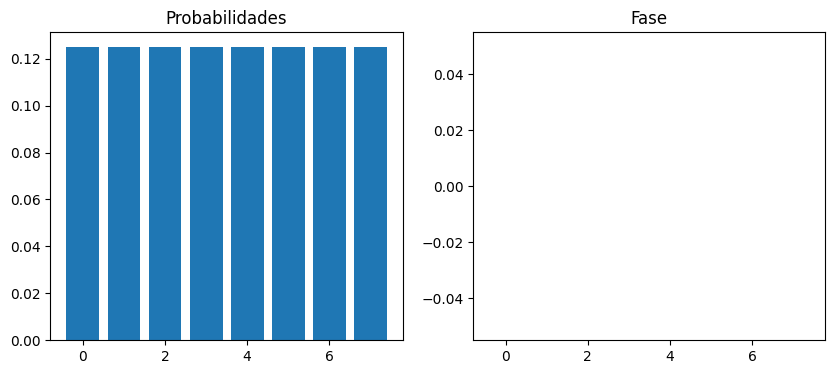

In [ ]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit():

  # Puertas de Hadamard
  for i in range(3):
    qml.Hadamard(wires=i)

  # Devolvemos el estado final
  return qml.state()

probs = [abs(i)**2 for i in circuit()]
fases = [np.angle(i) for i in circuit()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(range(len(probs)), probs)
ax[0].set_title('Probabilidades')
ax[1].bar(range(len(probs)), fases)
ax[1].set_title('Fase')
plt.show()

Como vemos aquí, el efecto de **aplicar la puerta de Hadamard** es una **superposición** de los estados tal que todos tienen probabilidad $\frac{1}{8}$ de ser observados (y no tienen fase porque no se les ha aplicado ninguna rotación).

Vamos a aplicar una vez el **Hamiltoniano de Coste** con la función `qml.ApproxTimeEvolution(hamiltoniano_coste, gamma, n = 1)` para implementar $U_C(\gamma) = e^{-i\gamma H_C}$ una vez. Ocurre lo siguiente:

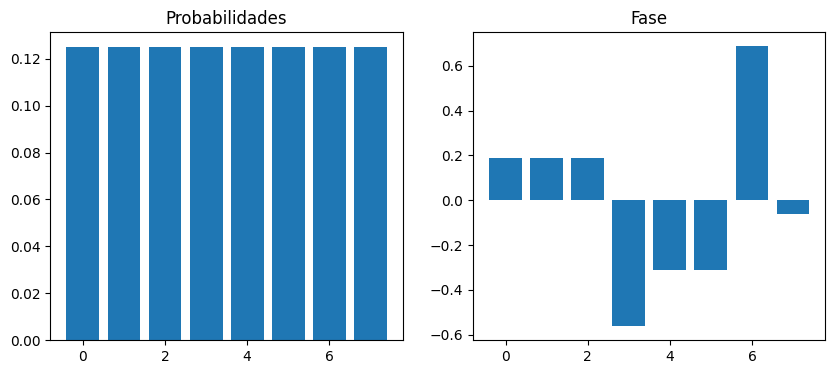

In [ ]:
dev = qml.device('default.qubit', wires=3)

gamma = 0.25

@qml.qnode(dev)
def circuit():

  # Puertas de Hadamard
  for i in range(3):
    qml.Hadamard(wires=i)

  # Hamiltoniano de Coste
  qml.ApproxTimeEvolution(hamiltoniano_coste, gamma, 1)

  # Devolvemos el estado
  return qml.state()

probs = [abs(i)**2 for i in circuit()]
fases = [np.angle(i) for i in circuit()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(range(len(probs)), probs)
ax[0].set_title('Probabilidades')
ax[1].bar(range(len(probs)), fases)
ax[1].set_title('Fase')
plt.show()

Ahora la cosa cambia, porque las fases de las posibles soluciones han cambiado según lo buenas que sean, podemos observar que la solución $6 = \{x_0 = 1,x_1 = 1, x_2 = 0\}$ tiene una mayor fase que las otras (de hecho, es la solución óptima del problema a minimizar), mientras que la solución $3 = \{x_0 = 0,x_1 = 1, x_2 = 1\}$ es la que menos fase tiene (y de hecho es la peor solución del problema a minimizar, es decir, la solución óptima del problema a maximizar). ¡Sin embargo, aún las probabilidades se mantienen intactas!

Si ahora aplicamos el Hamiltoniano de mezcla, ocurre lo siguiente:

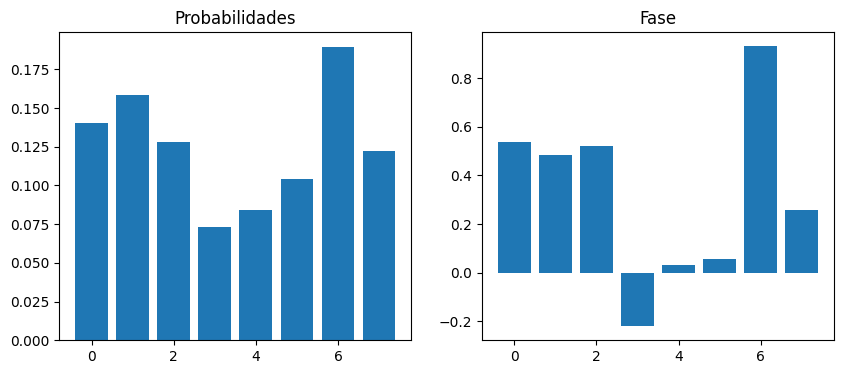

In [ ]:
dev = qml.device('default.qubit', wires=3)

gamma = 0.25
beta = -0.25

@qml.qnode(dev)
def circuit():

  # Puertas de Hadamard
  for i in range(3):
    qml.Hadamard(wires=i)

  # Hamiltoniano de Coste
  qml.ApproxTimeEvolution(hamiltoniano_coste, gamma, 1)

  # Hamiltoniano de mezcla
  for i in range(3):
    qml.RX(beta, wires=i)

  # Devolvemos el estado
  return qml.state()

probs = [abs(i)**2 for i in circuit()]
fases = [np.angle(i) for i in circuit()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(range(len(probs)), probs)
ax[0].set_title('Probabilidades')
ax[1].bar(range(len(probs)), fases)
ax[1].set_title('Fase')
plt.show()

Ahora vemos que la probabilidad de observación de nuestra solución óptima sí que ha cambiado, y que de hecho es la mayor de todas. Además, en este ejemplo en concreto, la fase de la solución óptima también ha aumentado, aunque lo normal es que disminuya.

¿Y si aumentamos el número de veces que aplicamos los Hamiltonianos de Coste y Mezcla? Prueba aquí a cambiar `n` para ver las consecuencias:

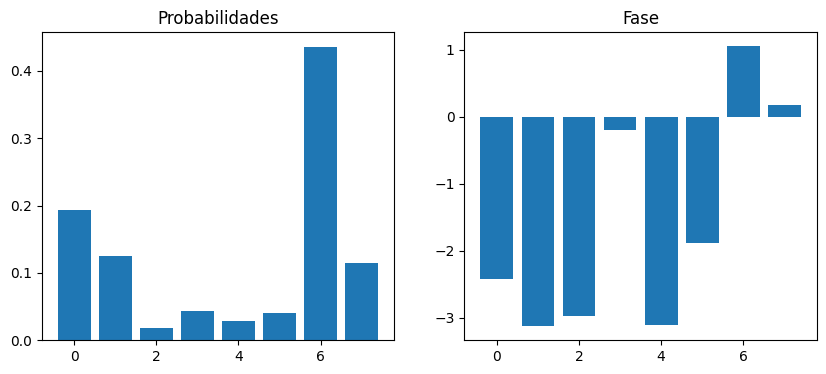

In [ ]:
dev = qml.device('default.qubit', wires=3)

gamma = 0.25
beta = -0.25

n = 10

@qml.qnode(dev)
def circuit():

  # Puertas de Hadamard
  for i in range(3):
    qml.Hadamard(wires=i)

  for j in range(n):

    # Hamiltoniano de Coste
    qml.ApproxTimeEvolution(hamiltoniano_coste, gamma, 1)

    # Hamiltoniano de mezcla
    for i in range(3):
      qml.RX(beta, wires=i)

  # Devolvemos el estado
  return qml.state()

probs = [abs(i)**2 for i in circuit()]
fases = [np.angle(i) for i in circuit()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(range(len(probs)), probs)
ax[0].set_title('Probabilidades')
ax[1].bar(range(len(probs)), fases)
ax[1].set_title('Fase')
plt.show()

Un apunte: los ángulos $\gamma$ y $\beta$ no tienen que ser iguales en cada iteración, pueden cambiar (y de hecho, es hasta recomendable; por eso optimizamos sus valores), porque si no puede ocurrir lo siguiente:

Vamos a estudiar la importancia del número de *ciclos* de Hamiltonianos de coste y mezcla. Y aunque pueda parecer que nos basta con establecer un número suficientemente grande para garantizar el obtener la solución que buscamos, no es así (al menos si los términos $\beta$ y $\gamma$ no varían o no son adecuados). Vamos a verlo con este ejemplo:



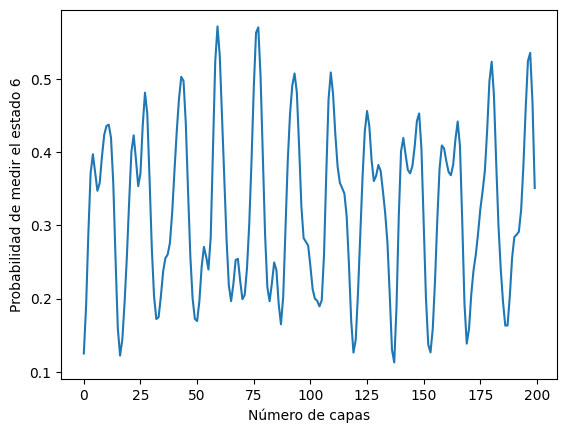

In [ ]:
dev = qml.device('default.qubit', wires=3)

gamma = 0.25
beta = -0.25

n_capas = 200

lista_probs_6 = []

for n in range(n_capas):

  @qml.qnode(dev)
  def circuit():

    # Puertas de Hadamard
    for i in range(3):
      qml.Hadamard(wires=i)

    for j in range(n):

      # Hamiltoniano de Coste
      qml.ApproxTimeEvolution(hamiltoniano_coste, gamma, 1)

      # Hamiltoniano de mezcla
      for i in range(3):
        qml.RX(beta, wires=i)

    # Devolvemos el estado
    return qml.state()

  lista_probs_6.append([abs(i)**2 for i in circuit()][6])

plt.plot(range(n_capas), lista_probs_6)
plt.xlabel('Número de capas')
plt.ylabel('Probabilidad de medir el estado 6')
plt.show()

Se ve cómo según el número de capas la probabilidad de observar la solución óptima al problema varía de gran forma (y eso que estamos en un problema de dimensión muy muy pequeña)

# Problema de Reparto de Números

Vamos a ver a continuación otro problema en el que ahora sí vamos a implementar el algoritmo QAOA completo (con la parte de optimización de parámetros). Vamos a considerar el siguiente problema: tenemos un **conjunto de objetos** con distintos **valores** $n_1,...,n_k$. El objetivo es dividir este conjunto en **dos grupos** de forma que la **suma de valores de los grupos sea lo más igualitaria posible** (no se pueden descartar objetos).

Un ejemplo: si tenemos el conjunto $[1,3,4,7,13]$, podemos formar los dos subgrupos: $[3,4,7]$ y $[13,1]$, los cuales suman ambos $14$.

A priori parace un problema sencillo de resolver mentalmente, pero cuando a medida que el conjunto de objetos crece y crece, los cálculos se vuelven más difíciles. Y probar todas las combinaciones no es buena idea porque la complejidad computacional crece exponencialmente... ¡Por eso podemos recurrir al QAOA para resolverlo!

Vamos a definir la siguiente función de coste: sea $L = \{n_1,...n_k\}$ nuestro conjunto de objetos que queremos partir en $L_1$ y $L_2$. La función de coste es:

$$
f_L(\vec{s}) = \bigg( \sum_{i=1}^k n_is_i \bigg)^2 = \sum_{i}^k \sum_{j}^k n_in_js_is_j
$$

donde $s_i = 1$ si $n_i \in L_1$ y $s_i = -1$ si $n_i \in L_2$. Esta función encuentra su mínimo cuando los valores en $L_1$ y $L_2$ son iguales porque

$$
f_L(\vec{s}) = \bigg(\sum_{n_i \in L_1} n_is_i + \sum_{n_i \in L_2} n_is_i \bigg)^2 = \bigg(\sum_{n_i \in L_1} n_i - \sum_{n_i \in L_2} n_i\bigg)^2
$$

que será más pequeña cuanto más parecidas sean las sumas de los valores de cada grupo.

El definir el problema de esta forma además tiene una ventaja: no tenemos que hacer ningún cambio de variable para expresar el problema en términos cuánticos porque las variables pueden tomar los valores $\{1, -1\}$, ¡igual que los elementos de $Z$! El mapeo es instantáneo.

Definimos los términos del problema:

In [3]:
numbers = [1,3,4,7,13]
n_wires = len(numbers)

Ahora definimos la función del Hamiltoniano de coste:

In [21]:
def cost_hamiltonian(numbers):
    coeffs = []
    ops = []
    for i in range(n_wires):
        for j in range(n_wires):
            if i<j:
                coeff = numbers[i] * numbers[j]
                op = qml.Z(i) @ qml.Z(j)
                coeffs.append(coeff)
                ops.append(op)
    return qml.Hamiltonian(coeffs, ops)

H_cost = cost_hamiltonian(numbers)

Ahora definimos las capas del circuito, tanto la que implementa el Hamiltoniano de coste como la que implementa el de mezcla:

In [5]:
def cost_layer(gamma):
    qml.ApproxTimeEvolution(H_cost, gamma, 1)

def mixer_layer(beta):
    for i in range(n_wires):
        qml.RX(beta, wires=i)

Definimos ahora el circuito:

In [40]:
p = 3 # Número de capas
dev = qml.device('default.qubit', wires=n_wires)

def ansatz(params):
    gammas = params[:p]
    betas = params[p:]

    for i in range(n_wires):
        qml.Hadamard(wires=i)

    for i in range(p):
        cost_layer(gammas[i])
        mixer_layer(betas[i])


@qml.qnode(dev)
def cost_function(params):
    ansatz(params)
    return qml.expval(H_cost)

@qml.qnode(dev)
def prob_fn(params):
    ansatz(params)
    return qml.probs(wires=range(n_wires))

Ahora definimos la parte de optimización de parámetros:

In [41]:
np.random.seed(42)
init_params = np.random.uniform(0, np.pi, 2 * p)
params = init_params

stepsize = 0.005

opt = qml.optimize.AdamOptimizer(stepsize)
steps = 300

for i in range(steps):
    cost_i = cost_function(params)
    params = opt.step(cost_function, params)
    print(f"Step {i + 1}: Cost = {cost_i:.6f}")

Step 1: Cost = -34.212655
Step 2: Cost = -63.803262
Step 3: Cost = -15.911823
Step 4: Cost = -14.730957
Step 5: Cost = -27.550065
Step 6: Cost = -48.736912
Step 7: Cost = -46.470465
Step 8: Cost = -45.786974
Step 9: Cost = -44.055579
Step 10: Cost = -44.828938
Step 11: Cost = -53.410045
Step 12: Cost = -59.235727
Step 13: Cost = -55.072900
Step 14: Cost = -52.600641
Step 15: Cost = -57.225430
Step 16: Cost = -62.230057
Step 17: Cost = -63.080415
Step 18: Cost = -61.762216
Step 19: Cost = -60.636764
Step 20: Cost = -60.106717
Step 21: Cost = -59.989508
Step 22: Cost = -60.311865
Step 23: Cost = -61.096124
Step 24: Cost = -62.156098
Step 25: Cost = -63.403432
Step 26: Cost = -65.019295
Step 27: Cost = -67.063947
Step 28: Cost = -68.987695
Step 29: Cost = -69.662858
Step 30: Cost = -68.739640
Step 31: Cost = -68.037672
Step 32: Cost = -68.885483
Step 33: Cost = -69.912551
Step 34: Cost = -70.226049
Step 35: Cost = -70.851544
Step 36: Cost = -71.943390
Step 37: Cost = -71.977747
Step 38: C

Ya hemos optimizado los parámetros! Ejecutemos una última vez el circuito y veamos los resultados


Top bitstrings (most probable):
(1, 0, 0, 0, 1): 0.1823
(0, 1, 1, 1, 0): 0.1823
(1, 0, 1, 0, 1): 0.1697
(0, 1, 0, 1, 0): 0.1697
(1, 0, 1, 1, 0): 0.0339
(0, 1, 0, 0, 1): 0.0339
(1, 0, 0, 1, 0): 0.0233
(0, 1, 1, 0, 1): 0.0233
(1, 1, 1, 0, 0): 0.0225
(0, 0, 0, 1, 1): 0.0225

Best partition (from most probable bitstring):
Group 0: [3, 4, 7]  (sum = 14)
Group 1: [1, 13]  (sum = 14)
Difference: 0



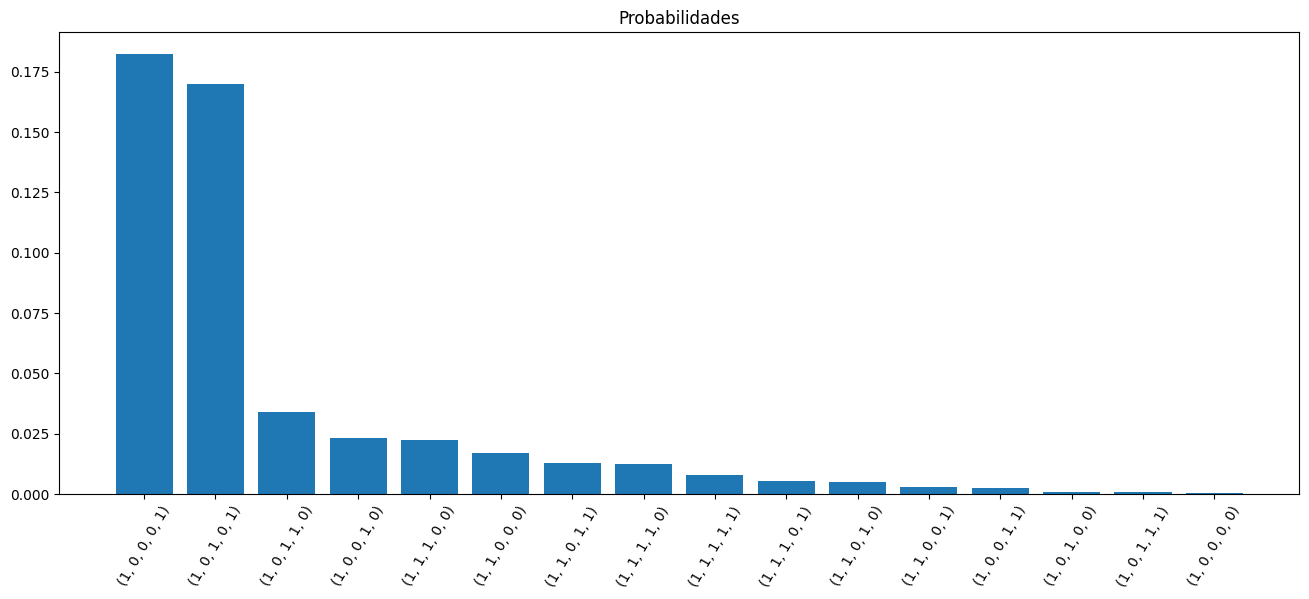

In [42]:
probs = prob_fn(params)
bitstrings = list(product([0, 1], repeat=n_wires))
sorted_results = sorted(zip(probs, bitstrings), reverse=True)

print("\nTop bitstrings (most probable):")
for prob, bits in sorted_results[:10]:
    print(f"{bits}: {prob:.4f}")

def print_partition(bitstring, numbers):
    group_0 = [num for bit, num in zip(bitstring, numbers) if bit == 0]
    group_1 = [num for bit, num in zip(bitstring, numbers) if bit == 1]
    sum_0 = sum(group_0)
    sum_1 = sum(group_1)
    print(f"Group 0: {group_0}  (sum = {sum_0})")
    print(f"Group 1: {group_1}  (sum = {sum_1})")
    print(f"Difference: {abs(sum_0 - sum_1)}\n")
print("\nBest partition (from most probable bitstring):")
print_partition(sorted_results[0][1], numbers)

sorted_results_sin_rep = []
for i in range(len(sorted_results)):
    if i%2 == 0:
        sorted_results_sin_rep.append(sorted_results[i])

grupos = [sorted_results_sin_rep[i][0] for i in range(len(sorted_results_sin_rep))]
probs = [''.join(str(sorted_results_sin_rep[i][1])) for i in range(len(sorted_results_sin_rep))]

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(probs, grupos)
ax.tick_params(axis='x', labelrotation=60)
ax.set_title('Probabilidades')
plt.show()